In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [16]:
num_features = 2
num_clusters = 3
num_samples_per_cluster = 1000
seed = 700
centroids = np.array([[10,-80], [-20, 90],[40, 50]])
np.random.seed(seed)

In [17]:
def create_samples(num_clusters, num_samples_per_cluster, num_features, seed):
    np.random.seed(seed)
    slices = []
    # Create samples for each cluster
    for i in range(num_clusters):
        cluster_samples = tf.random_normal((num_samples_per_cluster, num_features),
                                   mean=0.0, stddev=5.0, dtype=tf.float32, seed=seed, name="cluster_{}".format(i))
        current_centroid = centroids[i,:]
        cluster_samples = cluster_samples + current_centroid
        slices.append(cluster_samples)

    samples = tf.concat(slices, 0, name='samples')
    return samples

def plot_clusters(all_samples, centroids, num_samples_per_cluster):
    #Plot out the different clusters
    #Choose a different colour for each cluster
    #colour = plt.cm.rainbow(np.linspace(0,1,centroids.shape[0]))
    colour = itertools.cycle(["#F97559", "#C4EE39", "#7F92FE"])
    for i, centroid in enumerate(centroids):
         #Grab just the samples fpr the given cluster and plot them out with a new colour
         samples = all_samples[i*num_samples_per_cluster:(i+1)*num_samples_per_cluster]
         plt.scatter(samples[:,0], samples[:,1], c=next(colour))
         #Also plot centroid
         plt.plot(centroid[0], centroid[1], markersize=3, marker="x", color='k', mew=10)
         #plt.plot(centroid[0], centroid[1], markersize=3, marker="x", color='m', mew=5)
    plt.show()

In [18]:
samples = create_samples(num_clusters, num_samples_per_cluster, num_features, seed)

model = tf.global_variables_initializer()
with tf.Session() as session:
    sample_values = session.run(samples)

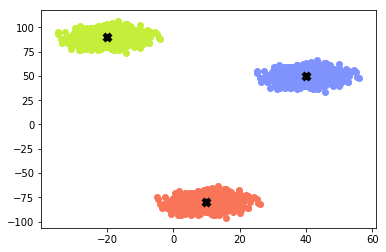

In [19]:
plot_clusters(sample_values, centroids, num_samples_per_cluster)

In [20]:
sample_values.shape

(3000, 2)

In [21]:
def choose_random_centroids(samples, n_clusters):
    # Step 0: Initialisation: Select `n_clusters` number of random points
    n_samples = tf.shape(samples)[0]
    random_indices = tf.random_shuffle(tf.range(0, n_samples))
    centroid_indices = tf.slice(random_indices, [0], [n_clusters])
    initial_centroids = tf.gather(samples, centroid_indices)
    return initial_centroids

In [22]:
initial_centroids = choose_random_centroids(samples, num_clusters)

In [23]:
initial_centroids

<tf.Tensor 'Gather_1:0' shape=(3, 2) dtype=float32>

In [24]:
def assign_to_nearest(samples, centroids):
    # Finds the nearest centroid for each sample

    # START from http://esciencegroup.com/2016/01/05/an-encounter-with-googles-tensorflow/
    expanded_vectors = tf.expand_dims(samples, 0)
    expanded_centroids = tf.expand_dims(centroids, 1)
    distances = tf.reduce_sum( tf.square(
               tf.subtract(expanded_vectors, expanded_centroids)), 2)
    nearest_indices = tf.argmin(distances, 0)
    return nearest_indices

def update_centroids(samples, nearest_indices, n_clusters):
    # Updates the centroid to be the mean of all samples associated with it.
    nearest_indices = tf.to_int32(nearest_indices)
    partitions = tf.dynamic_partition(samples, nearest_indices, n_clusters)
    new_centroids = tf.concat([tf.expand_dims(tf.reduce_mean(partition, 0), 0) for partition in partitions], 0)
    return new_centroids

In [25]:
model = tf.global_variables_initializer()
nearest_indices = assign_to_nearest(samples, initial_centroids)
updated_centroids = update_centroids(samples, nearest_indices, num_clusters)

with tf.Session() as session:
    session.run(model)
    updated_centroid_value,indices_values = session.run([updated_centroids, nearest_indices])
    print(updated_centroid_value)      
    nearest_indices = assign_to_nearest(samples, updated_centroids)
    updated_centroids = update_centroids(samples, nearest_indices, num_clusters)    
    for i in range(100):
        updated_centroid_value = session.run([updated_centroids])
        indice_values = session.run([nearest_indices])
        print(updated_centroid_value)

[[ 23.29606247  62.14813232]
 [-23.5951786   89.65250397]
 [  9.88516712 -79.98561096]]
[[ 39.92517853  50.15761948]
 [  9.92518711 -79.84238434]
 [-20.07481384  90.15762329]]
[[  9.94699764 -80.08620453]
 [ 39.9469986   49.91378021]
 [-20.05300331  89.91378784]]
[[-19.71530151  89.8839035 ]
 [ 10.28469944 -80.11608124]
 [ 40.28469467  49.88391495]]
[[-20.09224319  90.18404388]
 [  9.90775585 -79.81595612]
 [ 39.90775681  50.18405914]]
[[-19.19299316  92.65913391]
 [  8.39514828  69.82636261]
 [ 22.4662075  -29.94638824]]
[[  9.91693878 -79.77284241]
 [-20.08306122  90.22715759]
 [ 39.91693878  50.22716522]]
[[  4.27980185 -82.34171295]
 [ 12.10281372 -79.26512146]
 [ 10.01406956  69.91342163]]
[[  9.82644749  70.06259155]
 [ 13.09908581 -75.6908493 ]
 [  8.22183132 -82.01953888]]
[[-19.91207504  89.92737579]
 [ 40.08792877  49.92738342]
 [ 10.08792782 -80.07260895]]
[[-20.23379517  89.91371918]
 [  9.76620674 -80.08628082]
 [ 39.76621246  49.91371155]]
[[-20.11985588  90.20803833]
 [ 

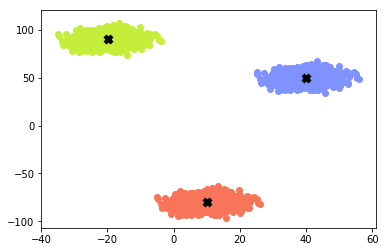

In [26]:
plot_clusters(sample_values, updated_centroid_value, num_samples_per_cluster)